<font size=4>
    Here is a step by step, more controlled implementation of URF protocol.
    <br><br>
</font>

### Requirements <br>
<font size=4>
    X - input data <br>
</font>
<font size=3>
    &emsp; a high dimensional 2d numpy array <br>
    &emsp; if input data from multiple MD trajectories, then X has to be concatednated <br>
    &emsp; in the original work, only continuous data was tested, coming from internal coordiantes of proteins via MD simulations <br><br>
</font>

In [1]:
import numpy as np

In [2]:
X = np.load('../data/input_data.npy')
X.shape

(24149, 229)

### URF

In [3]:
import sys
sys.path.append('../scripts/0_python_modules/') 
# this can also be ../URF path via alternative.txt

In [5]:
import synthetic_data as syn
from sklearn.ensemble import RandomForestClassifier as rfc
from sklearn.model_selection import train_test_split as splt
import scipy.cluster as scc
import proximity_matrix as pmt
import extras  #renamed as utils in URF
import cluster
import metrics

#### synthetic data

In [7]:
dsyn = syn.synthetic_data(X, size=1)
dsyn.permute()   # may be dsyn.{marginal, nonsense, random etc}, nonsense indicate fictitious
pfeatures, plabels = dsyn.get_output()

In [8]:
# pfeatures and plabels are synthetic data+real data and artificial labels

#### RF1

In [10]:
np.random.seed(0)
rf1_cv=5
random_states = np.random.randint(0,1000,rf1_cv)

In [11]:
clfs=[]
for i in range(rf1_cv):
    clf = rfc(n_estimators=1000, random_state=random_states[i], n_jobs=16)
    x,_,y,_ = splt(pfeatures, plabels, train_size=0.3, random_state=random_states[i])
    clf.fit(x,y)
    clfs.append(clf)

#### proximity estimations

In [12]:
prox = pmt.calculate_condenced_pmt_(clfs, X, n_jobs=24)
# here the size of X can be controlled, as implemented via efficient scheme
# different schemes are available in proximity_matrix.py and cluster.py

#### hierarchical classes

In [13]:
hc = scc.hierarchy.linkage(prox, method='average')
# low-mem and fit-predict clustering schemes are available in cluster.py

In [15]:
nhc=2
Y = extras.get_hc_dtraj(hc, nids=nhc)

#### RF2

In [16]:
np.random.seed(0)
rf2_cv=5
random_states = np.random.randint(0,1000,rf2_cv)

In [19]:
fimp = np.zeros((rf2_cv, X.shape[1]))
LC = np.zeros((rf2_cv))
for i in range(rf2_cv):
    clf = rfc(n_estimators=1000, n_jobs=24, random_state=random_states[i])
    xtrain, xtest, ytrain, ytest = splt(X, Y, test_size=0.3, random_state=random_states[i])
    clf.fit(xtrain, ytrain)
    fimp[i]=clf.feature_importances_
    LC[i] = metrics.learning_coefficient(Y, clf, xtest, ytest,
                                        cfactor=2, b=0, a=1, penalty=0)

### the fimp and LC are output

In [20]:
LC

array([0.99331889, 0.99487179, 0.99460127, 0.99420908, 0.99365386])

In [21]:
import matplotlib.pyplot as plt

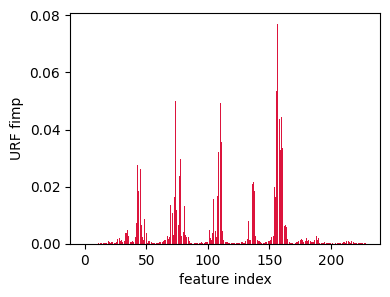

In [24]:
plt.bar(range(fimp.shape[1]), np.mean(fimp, axis=0), color='crimson')
plt.ylim(0,)
plt.xlabel('feature index')
plt.ylabel('URF fimp')
plt.show()

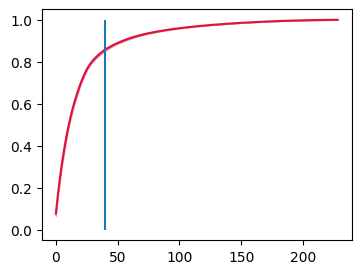

array([0.86173907, 0.85104688, 0.86528332, 0.85716706, 0.85554571])

In [25]:
cumsum = [np.cumsum(i[i.argsort()[::-1]]) for i in fimp]
plt.fill_between(range(fimp.shape[1]), 
                 np.mean(cumsum, axis=0)-np.std(cumsum, axis=0), np.mean(cumsum, axis=0)+np.std(cumsum,axis=0),
                color='crimson', alpha=0.4)
plt.plot(range(fimp.shape[1]), np.mean(cumsum, axis=0), color='crimson')
plt.vlines([40],0,1,)
plt.show()
np.array(cumsum)[:,40]